# Training: Neuronales Netzwerk mit dem Tuner von Weights & Biases

In diesem Notebook wird ein neuronales Netzwerk mit dem [Tuner von Weights & Biases](https://colab.research.google.com/github/wandb/examples/blob/master/colabs/tensorflow/Hyperparameter_Optimization_in_TensorFlow_using_W%26B_Sweeps.ipynb#scrollTo=crY5iadfKp_b) trainiert. Der Tuner von Weights & Biases ist ein Tool, das automatisiert die Hyperparameter eines Modells optimiert. In diesem Fall wird der Tuner verwendet, um die Batch Size als Hyperparameter zu optimieren. Dabei ist das Ziel den Validierungsfehler zu minimieren.

Zunächst werden alle nötigen Bibliotheken importiert.

In [30]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import os
import keras_tuner as kt
import wandb
import tqdm
import tensorflow as tf
import keras
import seaborn as sns

from tensorflow.keras import layers, Model, optimizers, losses, callbacks
from tensorflow import GradientTape
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
from wandb.integration.keras import WandbMetricsLogger
from sklearn.metrics import confusion_matrix

Anschließend können die verwendeten Datensätze geladen werden.

In [31]:
train = pd.read_csv('../data/preprocessed/train_data.csv')
test = pd.read_csv('../data/preprocessed/test_data.csv')
val = pd.read_csv('../data/preprocessed/val_data.csv')

In [32]:
train.shape, test.shape, val.shape

((50176, 48), (5469, 48), (10752, 48))

In [33]:
X_train = train.drop("Is high risk", axis=1)
Y_train = train["Is high risk"]

X_test = test.drop("Is high risk", axis=1)
Y_test = test["Is high risk"]

X_val = val.drop("Is high risk", axis=1)
Y_val = val["Is high risk"]

In [34]:
# wandb.login()

Nun werden die Funktionen für das neuronale Netzwerk definiert. Dabei wird ein einfaches Netzwerk mit vier versteckten Schichten mit jeweils 64 Neuronen und der ReLU-Aktivierungsfunktion verwendet. Weiterhin wird die Funktion für die Trainingsschritte und die Testschritte definiert.

In [35]:
def Model():
    x = layers.Input(shape=(X_train.shape[1],))

    h = layers.Dense(64, activation='relu')(x)
    h = layers.Dense(64, activation='relu')(h)
    h = layers.Dense(64, activation='relu')(h)
    h = layers.Dense(64, activation='relu')(h)

    y = layers.Dense(1, activation='sigmoid')(h)

    model = keras.Model(inputs=x, outputs=y)

    return model

def train_step(x, y, model, optimizer, loss_fn, train_acc_metric):
    with GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = loss_fn(y, logits)

    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    train_acc_metric.update_state(y, logits)

    return loss_value

def test_step(x, y, model, loss_fn, val_acc_metric):
    val_logits = model(x, training=False)
    loss_value = loss_fn(y, val_logits)
    val_acc_metric.update_state(y, val_logits)

    return loss_value

Basierend auf den zuvor erstellten Funktionen wird nun die Trainingsfunktion erstellt. Dabei wird Weight & Biases verwendet, um den Trainingsprozess zu tracken.

In [36]:
def train(train_dataset,
          val_dataset, 
          model,
          optimizer,
          loss_fn,
          train_acc_metric,
          val_acc_metric,
          epochs=1000, 
          log_step=200, 
          val_log_step=50):
    for epoch in range(epochs):
        print("\nStart of epoch %d" % (epoch,))

        train_loss = []   
        val_loss = []

        # Iterate over the batches of the dataset
        for step, (x_batch_train, y_batch_train) in tqdm.tqdm(enumerate(train_dataset), total=len(train_dataset)):
            loss_value = train_step(x_batch_train, y_batch_train, 
                                    model, optimizer, 
                                    loss_fn, train_acc_metric)
            train_loss.append(float(loss_value))

        # Run a validation loop at the end of each epoch
        for step, (x_batch_val, y_batch_val) in enumerate(val_dataset):
            val_loss_value = test_step(x_batch_val, y_batch_val, 
                                       model, loss_fn, 
                                       val_acc_metric)
            val_loss.append(float(val_loss_value))
            
        # Display metrics at the end of each epoch
        train_acc = train_acc_metric.result()
        print("Training acc over epoch: %.4f" % (float(train_acc),))

        val_acc = val_acc_metric.result()
        print("Validation acc: %.4f" % (float(val_acc),))

        # Reset metrics at the end of each epoch
        train_acc_metric.reset_state()
        val_acc_metric.reset_state()

        # log metrics using wandb.log
        wandb.log({'epochs': epoch,
                   'loss': np.mean(train_loss),
                   'acc': float(train_acc), 
                   'val_loss': np.mean(val_loss),
                   'val_acc':float(val_acc)})

Nun werden die Parameter für die optimierung in der `sweep_config` definiert.

In [37]:
sweep_config = {
  'method': 'grid', 
  'metric': {
      'name': 'val_loss',
      'goal': 'minimize'
  },
  'early_terminate':{
      'type': 'hyperband',
      'min_iter': 5
  },
  'parameters': {
      'batch_size': {
          'values': [32, 64, 128, 256, 512]
      }
  }
}

Anschließend wird die `sweep_train`-Funktion erstellt. Diese nutzt die zuvor definierte Trainingsfunktion und führt sie mit der `swep_config` zusammen, um den Optimierungsprozess in sogenannten Sweeps durchzuführen und auf Weight & Biases zu tracken.

In [38]:
def sweep_train(config_defaults=None):
    # Set default values
    config_defaults = {
        "batch_size": 32,
        "learning_rate": 0.001
    }
    # Initialize wandb with a sample project name
    wandb.init(config=config_defaults)  # this gets over-written in the Sweep

    # Specify the other hyperparameters to the configuration, if any
    wandb.config.epochs = 10
    wandb.config.log_step = 20
    wandb.config.val_log_step = 50
    wandb.config.architecture_name = "test"
    wandb.config.dataset_name = "Credit Card"

    # build input pipeline using tf.data
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
    train_dataset = (train_dataset.batch(wandb.config.batch_size)
                                  .prefetch(buffer_size=tf.data.AUTOTUNE)
                                  .shuffle(buffer_size=50176)
                                  )

    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val))
    val_dataset = (val_dataset.batch(wandb.config.batch_size)
                              .prefetch(buffer_size=tf.data.AUTOTUNE)
                              .shuffle(buffer_size=10752)
                              )

    # initialize model
    model = Model()

    # Instantiate an optimizer to train the model.
    # optimizer = keras.optimizers.SGD(learning_rate=wandb.config.learning_rate)
    optimizer = optimizers.Adam(learning_rate=wandb.config.learning_rate, 
                            beta_1=0.9, 
                            beta_2=0.999, 
                            amsgrad=True)
    # Instantiate a loss function.
    loss_fn = keras.losses.BinaryCrossentropy(from_logits=False)

    # Prepare the metrics.
    train_acc_metric = keras.metrics.BinaryAccuracy()
    val_acc_metric = keras.metrics.BinaryAccuracy()

    train(train_dataset,
          val_dataset, 
          model,
          optimizer,
          loss_fn,
          train_acc_metric,
          val_acc_metric,
          epochs=wandb.config.epochs, 
          log_step=wandb.config.log_step, 
          val_log_step=wandb.config.val_log_step)

Nun wird ein neuer Sweep erstellt und die `sweep_train`-Funktion aufgerufen, um den Optimierungsprozess zu starten.

In [39]:
sweep_id = wandb.sweep(sweep_config, project="test-sweep")

Create sweep with ID: pm2526bc
Sweep URL: https://wandb.ai/lokrau/test-sweep/sweeps/pm2526bc


In [40]:
wandb.agent(sweep_id, function=sweep_train, count=5)

wandb: Agent Starting Run: ls75vlmx with config:
wandb: 	batch_size: 32
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.



Start of epoch 0


100%|██████████| 1568/1568 [00:23<00:00, 66.26it/s]
2024-06-07 19:31:35.837439: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training acc over epoch: 0.5092
Validation acc: 0.4971

Start of epoch 1


100%|██████████| 1568/1568 [00:23<00:00, 66.64it/s]
2024-06-07 19:32:00.072684: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training acc over epoch: 0.5211
Validation acc: 0.5164

Start of epoch 2


100%|██████████| 1568/1568 [00:23<00:00, 66.91it/s]
2024-06-07 19:32:24.197962: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training acc over epoch: 0.5270
Validation acc: 0.5001

Start of epoch 3


100%|██████████| 1568/1568 [00:22<00:00, 68.38it/s]
2024-06-07 19:32:47.828831: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training acc over epoch: 0.5299
Validation acc: 0.4980

Start of epoch 4


100%|██████████| 1568/1568 [00:22<00:00, 70.11it/s]
2024-06-07 19:33:10.878702: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training acc over epoch: 0.5230
Validation acc: 0.5096

Start of epoch 5


100%|██████████| 1568/1568 [00:22<00:00, 70.42it/s]
2024-06-07 19:33:33.888113: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training acc over epoch: 0.5348
Validation acc: 0.4815

Start of epoch 6


100%|██████████| 1568/1568 [00:24<00:00, 63.78it/s]
2024-06-07 19:33:59.183984: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training acc over epoch: 0.5247
Validation acc: 0.5025

Start of epoch 7


100%|██████████| 1568/1568 [00:25<00:00, 61.58it/s]
2024-06-07 19:34:25.331105: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training acc over epoch: 0.5456
Validation acc: 0.5203

Start of epoch 8


100%|██████████| 1568/1568 [00:22<00:00, 69.07it/s]
2024-06-07 19:34:48.714488: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training acc over epoch: 0.5308
Validation acc: 0.5089

Start of epoch 9


100%|██████████| 1568/1568 [00:22<00:00, 70.30it/s]
2024-06-07 19:35:11.716557: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training acc over epoch: 0.5225
Validation acc: 0.4970


acc,▁▃▄▅▄▆▄█▅▄
epochs,▁▂▃▃▄▅▆▆▇█
loss,█▁▁▁▁▁▁▁▁▁
val_acc,▄▇▄▄▆▁▅█▆▄
val_loss,█▁▂▃▁▁▁▁▁▁
acc,0.52252
epochs,9
loss,0.84932
val_acc,0.49702
val_loss,0.81653


wandb: Agent Starting Run: 4liy2zee with config:
wandb: 	batch_size: 64
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.



Start of epoch 0


100%|██████████| 784/784 [00:11<00:00, 65.44it/s]
2024-06-07 19:35:36.968488: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training acc over epoch: 0.4896
Validation acc: 0.4949

Start of epoch 1


100%|██████████| 784/784 [00:11<00:00, 65.51it/s]
2024-06-07 19:35:49.307102: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training acc over epoch: 0.5009
Validation acc: 0.4996

Start of epoch 2


100%|██████████| 784/784 [00:11<00:00, 65.61it/s]
2024-06-07 19:36:01.616848: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training acc over epoch: 0.5240
Validation acc: 0.5223

Start of epoch 3


100%|██████████| 784/784 [00:11<00:00, 65.63it/s]
2024-06-07 19:36:13.928407: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training acc over epoch: 0.5123
Validation acc: 0.5078

Start of epoch 4


100%|██████████| 784/784 [00:11<00:00, 65.43it/s]
2024-06-07 19:36:26.286300: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training acc over epoch: 0.5244
Validation acc: 0.5003

Start of epoch 5


100%|██████████| 784/784 [00:12<00:00, 61.64it/s]
2024-06-07 19:36:39.385483: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training acc over epoch: 0.5279
Validation acc: 0.5259

Start of epoch 6


100%|██████████| 784/784 [00:12<00:00, 63.97it/s]
2024-06-07 19:36:52.032186: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training acc over epoch: 0.5379
Validation acc: 0.5044

Start of epoch 7


100%|██████████| 784/784 [00:12<00:00, 63.96it/s]
2024-06-07 19:37:04.667043: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training acc over epoch: 0.5400
Validation acc: 0.5212

Start of epoch 8


100%|██████████| 784/784 [00:12<00:00, 64.30it/s]
2024-06-07 19:37:17.237909: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training acc over epoch: 0.5582
Validation acc: 0.4887

Start of epoch 9


100%|██████████| 784/784 [00:12<00:00, 63.90it/s]
2024-06-07 19:37:29.886124: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training acc over epoch: 0.5492
Validation acc: 0.5430


acc,▁▂▅▃▅▅▆▆█▇
epochs,▁▂▃▃▄▅▆▆▇█
loss,█▂▁▁▁▁▁▁▁▁
val_acc,▂▂▅▃▂▆▃▅▁█
val_loss,█▇▂▁▄▁▁▁▁▁
acc,0.54925
epochs,9
loss,1.32769
val_acc,0.54297
val_loss,1.16814


wandb: Agent Starting Run: x7v1r1zk with config:
wandb: 	batch_size: 128
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.



Start of epoch 0


100%|██████████| 392/392 [00:06<00:00, 62.84it/s]
2024-06-07 19:37:49.700786: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training acc over epoch: 0.4911
Validation acc: 0.5014

Start of epoch 1


100%|██████████| 392/392 [00:06<00:00, 62.53it/s]
2024-06-07 19:37:56.176497: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training acc over epoch: 0.5053
Validation acc: 0.4989

Start of epoch 2


100%|██████████| 392/392 [00:06<00:00, 63.09it/s]
2024-06-07 19:38:02.590060: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training acc over epoch: 0.5090
Validation acc: 0.5394

Start of epoch 3


100%|██████████| 392/392 [00:06<00:00, 62.71it/s]
2024-06-07 19:38:09.042159: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training acc over epoch: 0.5278
Validation acc: 0.5011

Start of epoch 4


100%|██████████| 392/392 [00:06<00:00, 63.34it/s]
2024-06-07 19:38:15.436030: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training acc over epoch: 0.5290
Validation acc: 0.5242

Start of epoch 5


100%|██████████| 392/392 [00:06<00:00, 63.21it/s]
2024-06-07 19:38:21.836872: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training acc over epoch: 0.5359
Validation acc: 0.5534

Start of epoch 6


100%|██████████| 392/392 [00:06<00:00, 63.03it/s]
2024-06-07 19:38:28.257082: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training acc over epoch: 0.5350
Validation acc: 0.5253

Start of epoch 7


100%|██████████| 392/392 [00:06<00:00, 62.92it/s]
2024-06-07 19:38:34.689889: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training acc over epoch: 0.5335
Validation acc: 0.5377

Start of epoch 8


100%|██████████| 392/392 [00:06<00:00, 62.67it/s]
2024-06-07 19:38:41.148404: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training acc over epoch: 0.5429
Validation acc: 0.5282

Start of epoch 9


100%|██████████| 392/392 [00:06<00:00, 63.11it/s]
2024-06-07 19:38:47.565962: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training acc over epoch: 0.5447
Validation acc: 0.5252


acc,▁▃▃▆▆▇▇▇██
epochs,▁▂▃▃▄▅▆▆▇█
loss,█▂▁▁▁▁▁▁▁▁
val_acc,▁▁▆▁▄█▄▆▅▄
val_loss,█▂▁▁▁▁▁▁▁▁
acc,0.54468
epochs,9
loss,1.91342
val_acc,0.5252
val_loss,1.8366


wandb: Agent Starting Run: 9oy9jjln with config:
wandb: 	batch_size: 256
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.



Start of epoch 0


100%|██████████| 196/196 [00:03<00:00, 58.86it/s]
2024-06-07 19:39:05.188828: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training acc over epoch: 0.5415
Validation acc: 0.5000

Start of epoch 1


100%|██████████| 196/196 [00:03<00:00, 58.46it/s]
2024-06-07 19:39:08.666250: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training acc over epoch: 0.4744
Validation acc: 0.5048

Start of epoch 2


100%|██████████| 196/196 [00:03<00:00, 58.72it/s]2024-06-07 19:39:12.006636: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence

2024-06-07 19:39:12.130362: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training acc over epoch: 0.4850
Validation acc: 0.5007

Start of epoch 3


100%|██████████| 196/196 [00:03<00:00, 59.83it/s]
2024-06-07 19:39:15.526384: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training acc over epoch: 0.4944
Validation acc: 0.5117

Start of epoch 4


100%|██████████| 196/196 [00:03<00:00, 59.72it/s]
2024-06-07 19:39:18.930712: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training acc over epoch: 0.4797
Validation acc: 0.5076

Start of epoch 5


100%|██████████| 196/196 [00:03<00:00, 58.87it/s]
2024-06-07 19:39:22.383968: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training acc over epoch: 0.5074
Validation acc: 0.5315

Start of epoch 6


100%|██████████| 196/196 [00:03<00:00, 59.71it/s]
2024-06-07 19:39:25.791629: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training acc over epoch: 0.4768
Validation acc: 0.5187

Start of epoch 7


100%|██████████| 196/196 [00:03<00:00, 58.90it/s]
2024-06-07 19:39:29.246528: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training acc over epoch: 0.5076
Validation acc: 0.5138

Start of epoch 8


100%|██████████| 196/196 [00:03<00:00, 59.74it/s]
2024-06-07 19:39:32.649923: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training acc over epoch: 0.5233
Validation acc: 0.5036

Start of epoch 9


100%|██████████| 196/196 [00:03<00:00, 59.42it/s]
2024-06-07 19:39:36.072825: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training acc over epoch: 0.5234
Validation acc: 0.5080


acc,█▁▂▃▂▄▁▄▆▆
epochs,▁▂▃▃▄▅▆▆▇█
loss,█▂▂▂▁▁▁▁▁▁
val_acc,▁▂▁▄▃█▅▄▂▃
val_loss,█▁▆▁▂▁▁▁▁▁
acc,0.52342
epochs,9
loss,13.04489
val_acc,0.508
val_loss,12.941


wandb: Agent Starting Run: 6wr6m9tc with config:
wandb: 	batch_size: 512
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.



Start of epoch 0


100%|██████████| 98/98 [00:01<00:00, 55.82it/s]
2024-06-07 19:39:50.080827: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training acc over epoch: 0.5050
Validation acc: 0.5073

Start of epoch 1


100%|██████████| 98/98 [00:01<00:00, 56.26it/s]
2024-06-07 19:39:51.906973: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training acc over epoch: 0.4621
Validation acc: 0.4993

Start of epoch 2


100%|██████████| 98/98 [00:01<00:00, 55.89it/s]
2024-06-07 19:39:53.739053: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training acc over epoch: 0.4947
Validation acc: 0.4963

Start of epoch 3


100%|██████████| 98/98 [00:01<00:00, 56.74it/s]
2024-06-07 19:39:55.544610: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training acc over epoch: 0.5641
Validation acc: 0.5003

Start of epoch 4


100%|██████████| 98/98 [00:01<00:00, 55.94it/s]
2024-06-07 19:39:57.373032: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training acc over epoch: 0.4519
Validation acc: 0.5201

Start of epoch 5


100%|██████████| 98/98 [00:01<00:00, 56.35it/s]
2024-06-07 19:39:59.198248: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training acc over epoch: 0.5401
Validation acc: 0.5041

Start of epoch 6


100%|██████████| 98/98 [00:01<00:00, 56.17it/s]
2024-06-07 19:40:01.022367: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training acc over epoch: 0.5511
Validation acc: 0.5079

Start of epoch 7


100%|██████████| 98/98 [00:01<00:00, 56.18it/s]
2024-06-07 19:40:02.847000: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training acc over epoch: 0.5564
Validation acc: 0.5049

Start of epoch 8


  6%|▌         | 6/98 [00:00<00:02, 35.42it/s]


acc,▄▂▄█▁▇▇█
epochs,▁▂▃▄▅▆▇█
loss,█▄▂▂▂▂▁▁
val_acc,▄▂▁▂█▃▄▄
val_loss,█▄▂▄▁▆▁▄
acc,0.55644
epochs,7
loss,28.90393
val_acc,0.50493
val_loss,98.1269


Nun werden die Ergebnisse dieses Sweeps geladen.

In [42]:
api = wandb.Api()
sweep_id = 'lokrau/test-sweep/sweeps/' + sweep_id

sweep = api.sweep(sweep_id)
runs = sweep.runs

In [43]:
wandb.finish()

Diese ergebnisse werden in einer Liste gespeichert.

In [44]:
results = []
for run in runs:
    run_data = {
        'batch_size': run.config.get('batch_size'),
        'val_accuracy': run.summary.get('val_acc'),
        'val_loss': run.summary.get('val_loss'),
        'accuracy': run.summary.get('acc'),
        'loss': run.summary.get('loss'),
    }
    results.append(run_data)

In [45]:
results_df = pd.DataFrame(results)
results_df

,batch_size,val_accuracy,val_loss,accuracy,loss
0,512,0.504929,98.126903,0.556441,28.903931
1,256,0.507999,12.940995,0.523418,13.044885
2,128,0.525205,1.836598,0.544683,1.913423
3,64,0.542969,1.168136,0.549247,1.327692
4,32,0.497024,0.816527,0.522521,0.849320


Nun kann daraus der beste Run und damit die beste Batch Size ermittelt werden.

In [46]:
best_run = results_df.loc[results_df['val_loss'].idxmin()]
best_batch_size = best_run['batch_size']
best_val_loss = best_run['val_loss']

In [47]:
print(f'Best batch size: {best_batch_size} with validation accuracy: {best_val_loss}')

Best batch size: 32.0 with validation accuracy: 0.8165270629383269


Basierend darauf kann nun das neuronale Netzwerk mit der besten Batch Size trainiert werden.

In [48]:
model = Model()
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 47)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,617 (61.00 KB)

 Trainable params: 15,617 (61.00 KB)

 Non-trainable params: 0 (0.00 B)

Dabei wird mithilfe des Validierungsdatensatzes ein Early Stopping implementiert, um das Training zu stoppen, wenn der Validierungsfehler nicht mehr sinkt.

In [49]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    min_delta=0.001,     # Minimum change to qualify as an improvement
    patience=100,         # How many epochs to wait after last time val loss improved
    verbose=1,
    mode='min',          # The training will stop when the quantity monitored has stopped decreasing
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity.
)

Als Optimizer wird der Adam-Optimizer verwendet.

In [50]:
optimizer = optimizers.Adam(learning_rate=0.001, 
                            beta_1=0.9, 
                            beta_2=0.999, 
                            amsgrad=True)

model.compile(optimizer=optimizer, 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [51]:
batch_size = int(best_batch_size)
epochs = 1000

Nun wird Weight & Biases initialisiert, um den Trainingsprozess zu tracken.

In [52]:
# wandb.login()

Dazu wird ein neuer Run erstellt.

In [53]:
run = wandb.init(project='ml_assignment_wandb', 
                 config={
                     "learning_rate": 0.001, 
                     "epochs": epochs,
                     "batch_size": batch_size,
                     "loss_function": "BinaryCrossentropy",
                     "architecture": "Dense(64, relu) -> Dense(64, relu) -> Dense(64, relu) -> Dense(64, relu) -> Dense(1, sigmoid)",
                     "dataset": "Credit Card",
                     "optimizer": "Adam"})

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Anschließend kann das Training gestartet werden und der Trainingsprozess auf Weight & Biases mithilfe des `WandbMetricsLogger` getrackt werden.

In [54]:
history = model.fit(X_train, 
                    Y_train, 
                    batch_size=batch_size,
                    validation_data=(X_val, Y_val),
                    callbacks=[early_stopping, WandbMetricsLogger()],
                    epochs=epochs)

if not os.path.exists('../models'):
    os.makedirs('../models')

model.save('../models/model_wandb_tuning.h5')

Epoch 1/1000
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 2s 631us/step - accuracy: 0.5083 - loss: 190.1393 - val_accuracy: 0.4931 - val_loss: 22.5222
Epoch 2/1000
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 1s 574us/step - accuracy: 0.5256 - loss: 8.5659 - val_accuracy: 0.5049 - val_loss: 2.0612
Epoch 3/1000
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 1s 545us/step - accuracy: 0.5340 - loss: 2.7261 - val_accuracy: 0.4939 - val_loss: 3.2336
Epoch 4/1000
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 1s 542us/step - accuracy: 0.5459 - loss: 1.5479 - val_accuracy: 0.5207 - val_loss: 1.2690
Epoch 5/1000
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 1s 561us/step - accuracy: 0.5606 - loss: 1.1770 - val_accuracy: 0.5527 - val_loss: 1.1836
Epoch 6/1000
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 1s 548us/step - accuracy: 0.5533 - loss: 1.0451 - val_accuracy: 0.6031 - val_loss: 1.0215
Epoch 7/1000
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 1s 567us/step - accuracy: 0.5604 - loss: 0.9004 - val_accuracy: 0.5126 - val_loss: 0.9713
Epoch 8/1000
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 1s 543us/step -

In [55]:
wandb.finish()

epoch/accuracy,▁▂▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇▇▇▇▇█▇██▇▇█████████████
epoch/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▁▂▄▃▄▄▅▅▆▆▇▄▇▆▅▇▇▆▆█▄▆▇▇▇▇██▇▇▇▇██▇▆█▇█
epoch/val_loss,█▇▂▂▃▂▂▂▂▂▂▁▂▁▁▂▁▁▁▂▁▂▁▁▁▁▂▁▁▁▁▁▂▁▁▁▂▁▁▁
epoch/accuracy,0.82681
epoch/epoch,240
epoch/loss,0.37278
epoch/val_accuracy,0.84635
epoch/val_loss,0.59351


Nun wird der Trainingsverlauf des Modells für Accuracy und Loss visualisiert.

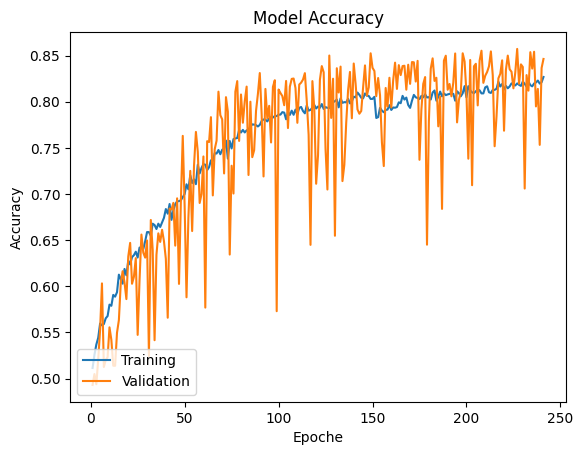

In [56]:
# Print the model training history for accuracy
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy)
plt.plot(epochs, val_accuracy)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoche')
plt.legend(['Training', 'Validation'], loc='lower left')
# plt.xticks(np.arange(1, len(accuracy)+1, 1))
plt.show()

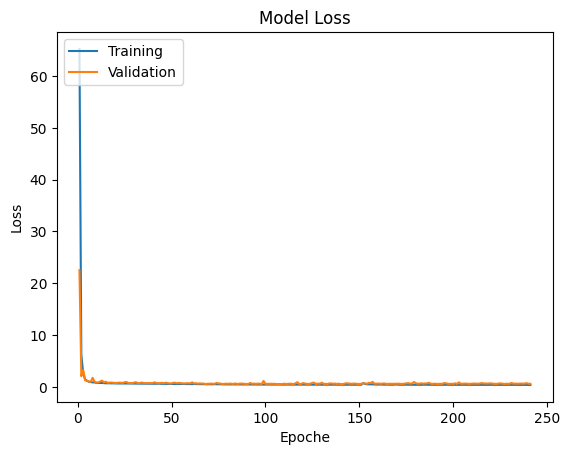

In [57]:
# print the model training history for loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoche')
plt.legend(['Training', 'Validation'], loc='upper left')
# plt.xticks(np.arange(1, len(loss)+1, 1))
plt.show()

Anschließend wird das Modell auf die drei zur verfügung stehenden Datensätze evaluiert und es ist zu erkennen, dass die Ergebnisse auf die drei Datensätze sehr ähnlich sind.

In [58]:
model.evaluate(X_test, Y_test)

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step - accuracy: 0.8396 - loss: 0.3745


[0.3810442388057709, 0.8365331888198853]

In [59]:
model.evaluate(X_val, Y_val)

336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step - accuracy: 0.8355 - loss: 0.4069


[0.5209344029426575, 0.8194754719734192]

In [60]:
model.evaluate(X_train, Y_train)

1568/1568 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step - accuracy: 0.8423 - loss: 0.3470


[0.3573133945465088, 0.8388671875]

Abschließend wird noch eine Confusion Matrix für die Testdaten erstellt, um die Ergebnisse des Modells zu visualisieren.

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step


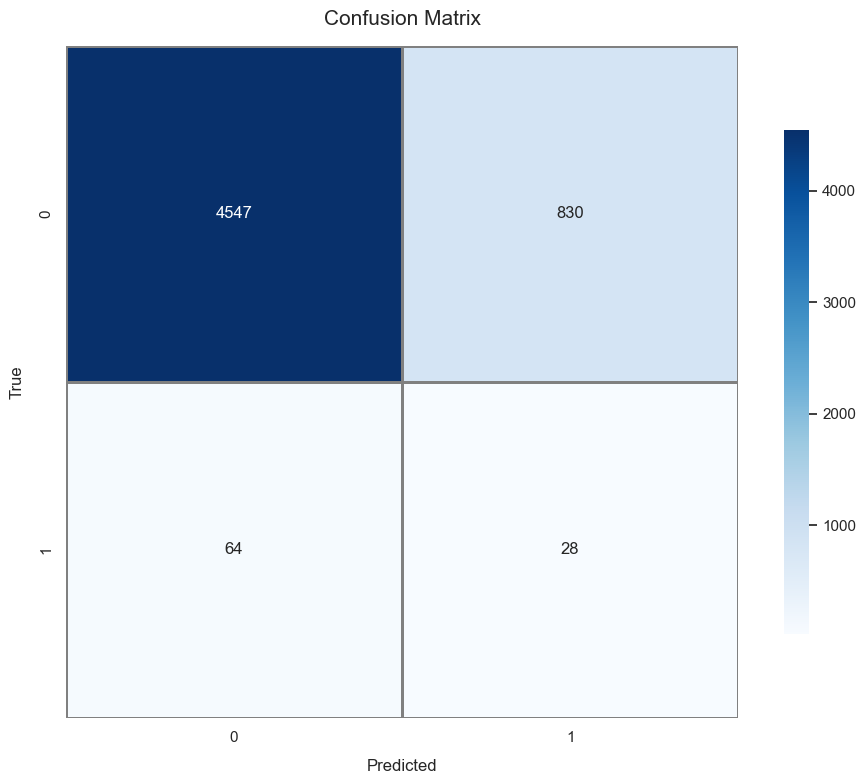

In [72]:
# make a confusion matrix for the test data
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

cm = confusion_matrix(Y_test, y_pred)

# Set the style of the heatmap
sns.set_theme(style="whitegrid")

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', square=True, cmap='Blues', cbar_kws={'shrink': 0.75}, linewidths=1, linecolor='grey')

# Add labels
plt.xlabel('Predicted', fontsize=12, labelpad=10)
plt.ylabel('True', fontsize=12, labelpad=10)
plt.title('Confusion Matrix', fontsize=15, pad=15)

# Improve the layout
plt.tight_layout()

# Display the plot
plt.show()
